In [3]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.optimize import leastsq
from scipy.optimize import least_squares
import time
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from matplotlib.colors import LogNorm
from scipy.signal import convolve as scipy_convolve

In [4]:
hdu = fits.open('3C264-1s-hanii-STARSUB.fits')
qso_data = hdu[1].data
qso_error = hdu[2].data
qso_header = hdu[1].header
wavestart = qso_header['CRVAL3']  # central wavelength = CDELT3 is microns per pixel. 
wavint = qso_header['CD3_3']  # wavelength interval
#wave = wavestart+np.arange(qso_data.shape[0])*wavint. This is the same as the one below. 
[central_x,central_y]= [55,58]#
qso_data[np.isnan(qso_data)] = 0.0000001
qso_error[np.isnan(qso_error)] = 0.000001
#(central_y,central_x) = ndimage.measurements.maximum_position(qso_data[1584,:,:])

In [5]:
mini_cube = qso_data[:,central_y - 22:central_y + 23,central_x - 22:central_x + 23]
mini_cube_error = qso_error[:,central_y - 22:central_y + 23,central_x - 22:central_x + 23]
qso_header['CRPIX1'] = qso_header['CRPIX1'] - (central_x - 22)
qso_header['CRPIX2'] = qso_header['CRPIX2'] - (central_y - 22)
new_hdu = fits.HDUList([fits.PrimaryHDU(mini_cube),fits.ImageHDU(mini_cube_error)])
new_hdu[0].header = qso_header
wave = np.arange(wavestart,(wavestart+(wavint*mini_cube.shape[0])),wavint)

In [6]:
z =0.02172 
k = 1+z
c = 300000
central_vel = c*z
wave = wave
#mini_data = qso_data
#mini_error = np.sqrt(qso_error)
mini_data = mini_cube
mini_error = np.sqrt(mini_cube_error)

In [7]:
select = (wave > 6400*k) & (wave < 6800*k)
select2 = (wave > 6552*k) & (wave < 6572*k) 
select3 = (wave > 6750*k) & (wave < 6780*k)
par = np.zeros((10,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
err = np.zeros((10,mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
fitted = np.zeros((np.shape(wave[select])[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)
residuals = np.zeros((np.shape(wave[select])[0],mini_data.shape[1],mini_data.shape[2]),dtype=np.float32)

In [8]:
# hdu = fits.open('table_3C264_extended_double_gauss.fits')
# central_tab = hdu[1].data
# central_columns = hdu[1].header
vel_core = 6511.82921461
vel_core_sigma = 103.01637393
vel_wing = 6501.11964805
vel_wing_sigma = 340.94087998  # from central fitting 

In [9]:
def redshift(vel):
    return vel/300000.0

def line_width(vel_sigma,rest_line,inst_res_fwhm=2.5):
    sigma = vel_sigma/(300000.0-vel_sigma)*rest_line
    return np.sqrt(sigma**2+(inst_res_fwhm/2.354)**2)

def gauss(wave,amplitude,vel,vel_sigma, rest_wave):
    line = (amplitude)*np.exp(-(wave-(rest_wave*(1+redshift(vel))))**2/(2*(line_width(vel_sigma, rest_wave))**2))
    return line 

def Ha_gauss(wave,amp_Ha,vel,vel_sigma):
    Ha = gauss(wave,amp_Ha,vel,vel_sigma,6562.85)
    return Ha

def NII_doublet_gauss(wave,amp_N6583,vel,vel_sigma):
    N_6548 = 0.33*gauss(wave,amp_N6583,vel,vel_sigma,6548.05)
    N_6583 = gauss(wave,amp_N6583,vel,vel_sigma,6583.45)
    return N_6548+N_6583

def SII_doublet_gauss(wave,amp_S6716,amp_S6731,vel,vel_sigma):
    S_6716 = gauss(wave,amp_S6716,vel,vel_sigma,6716.44)
    S_6731 = gauss(wave,amp_S6731,vel,vel_sigma,6731.82)
    return S_6716+S_6731

fixed_parameters = [vel_core,vel_core_sigma,vel_wing,vel_wing_sigma]  

def full_gauss(p,wave,data,error,fixed_parameters):    
    (amp_Ha,amp_Ha_br,amp_N6583,amp_N6583_br,amp_S6716,amp_S6716_br,amp_S6731,amp_S6731_br,m,c) = p
    [vel_core,vel_core_sigma,vel_wing,vel_wing_sigma] = fixed_parameters
    narrow_Ha = Ha_gauss(wave,amp_Ha,vel_core,vel_core_sigma)
    broad_Ha = Ha_gauss(wave,amp_Ha_br,vel_wing,vel_wing_sigma)
    narrow_NII = NII_doublet_gauss(wave,amp_N6583,vel_core,vel_core_sigma)
    broad_NII = NII_doublet_gauss(wave,amp_N6583_br,vel_wing,vel_wing_sigma)
    narrow_SII = SII_doublet_gauss(wave,amp_S6716,amp_S6731,vel_core,vel_core_sigma)
    broad_SII = SII_doublet_gauss(wave,amp_S6716_br,amp_S6731_br,vel_wing,vel_wing_sigma)
    cont = (wave/1000.0)*m+c
    return (narrow_Ha+broad_Ha+narrow_NII+broad_NII+narrow_SII+broad_SII+cont-data)/error

In [10]:
start = time.time()

for i in range(mini_data.shape[1]):
    for j in range(mini_data.shape[2]):
        y = mini_data[:,i,j][select]
        y_err = mini_error[:,i,j][select]
        x = wave[select]
        
#         emissData = mini_data[:,i,j][select2]
#         contData = mini_data[:,i,j][select3]
        
#         meanFlux = np.mean(emissData)
#         noise = np.std(contData)
        
#         SN = meanFlux/noise
#         #print(SN)

        lower_bounds = [0,0,0,0,0,0,0,0,-np.inf,-np.inf]
        upper_bounds = [np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]
        bounds_p_init = (lower_bounds,upper_bounds) 
                      
        try:
            result = least_squares(full_gauss,x0=[300,30,100,10,10,1,10,1,0,2],bounds=bounds_p_init,args = (x,y,y_err,fixed_parameters),max_nfev=10000000)
            popt1 = result['x']  
            
        except RuntimeError or RuntimeWarning:
            popt1 = [1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,0.0001,0.01]
            
#         if SN >= 1:
#             popt1,pcov1 = leastsq(full_gauss,x0=[300,30,100,10,10,1,10,1,0,2],args = (x,y,y_err,fixed_parameters),maxfev=10000000)
#         else:
#             popt1 = [1e-14,1e-14,1e-14,1e-14,1e-14,1e-14,1e-14,1e-14,0.0001,0.01]
        
        par[:,i,j] = popt1
        
#         model = full_gauss(popt1,x,y,y_err,fixed_parameters)*(y_err)+y
#         fitted[:,i,j] = model
        
#         #plt.plot(x,y)
#         #plt.plot(x,model)
#         #plt.show()
        
        residuals[:,i,j] = mini_data[:,i,j][select] - fitted[:,i,j]

        Monte_Carlo_loops = 100
        parameters_MC = np.zeros((len(popt1),Monte_Carlo_loops))
        
        for l in range(Monte_Carlo_loops):
            iteration_data = np.random.normal(y,y_err)
            try:
                result_MC = least_squares(full_gauss,x0=[300,30,100,10,10,1,10,1,0,2],bounds=bounds_p_init,args = (x,iteration_data,y_err,fixed_parameters),max_nfev=10000000)
                popt_MC = result_MC['x']  
            
            except RuntimeError or RuntimeWarning:
                popt_MC = [1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,1e-5,0.0001,0.01]
                
            parameters_MC[:,l]=popt_MC
            
        parameters_err = np.std(parameters_MC,1)
        err[:,i,j]=parameters_err
        

print("Time elapsed: ", str(time.time() - start))

Time elapsed:  7507.2266845703125


In [11]:
hdus=[]
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(par[0,:,:],name='amp_Ha'))
hdus.append(fits.ImageHDU(par[1,:,:],name='amp_Ha_br'))
hdus.append(fits.ImageHDU(par[2,:,:],name='amp_N6583'))
hdus.append(fits.ImageHDU(par[3,:,:],name='amp_N6583_br'))
hdus.append(fits.ImageHDU(par[4,:,:],name='amp_S6716'))
hdus.append(fits.ImageHDU(par[5,:,:],name='amp_S6716_br'))
hdus.append(fits.ImageHDU(par[6,:,:],name='amp_S6731'))
hdus.append(fits.ImageHDU(par[7,:,:],name='amp_S6731_br'))
hdus.append(fits.ImageHDU(par[8,:,:],name='m'))
hdus.append(fits.ImageHDU(par[9,:,:],name='c'))
hdu = fits.HDUList(hdus)

hdu.writeto('subcube_par_3C264_45x45_spec_100loops.fits',overwrite=True)

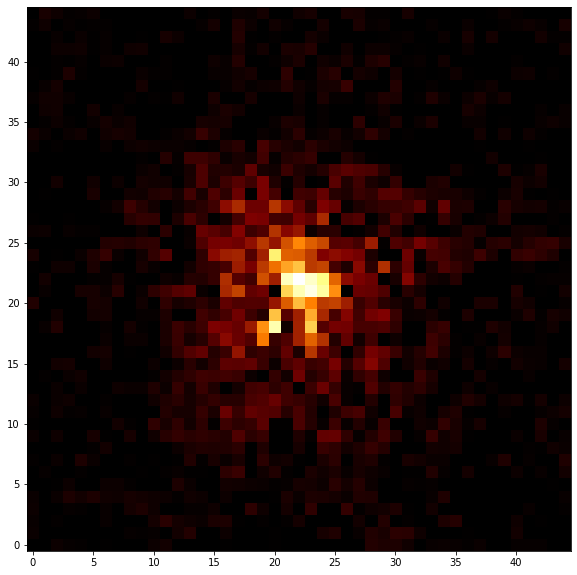

In [12]:
with fits.open('subcube_par_3C264_45x45_spec_100loops.fits') as hdu:

#hdu = fits.open('subcube_par_3C264_LSQ_45x45_updated.fits')

    Ha = hdu[1].data
    Ha_br = hdu[2].data
    N6583 = hdu[3].data
    N6583_br = hdu[4].data
    S6716 = hdu[5].data
    S6716_br = hdu[6].data
    S6731 = hdu[7].data
    S6731_br = hdu[8].data
    hdu.close()

plt.figure(figsize=(10,10))
plt.imshow(Ha_br,cmap='afmhot',origin='lower')

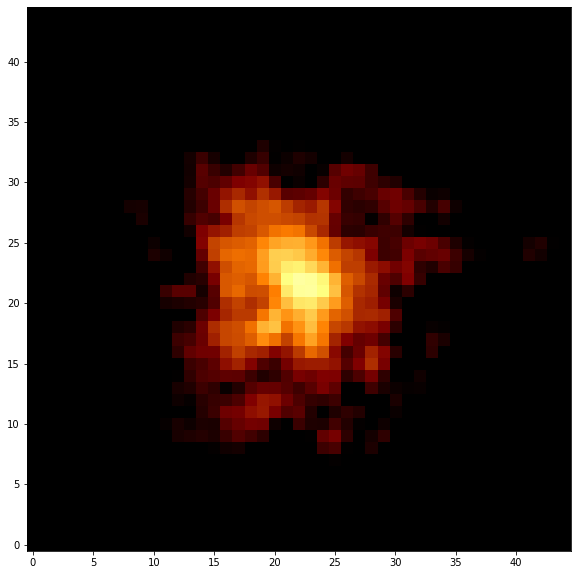

In [13]:
fig=plt.figure(figsize=(10,10))
kernel = Gaussian2DKernel(0.75)
smoothed_data_gauss = convolve(Ha_br, kernel)  #convolving takes the bad values and smooths them to more reasonable values. 
plt.imshow(smoothed_data_gauss,cmap='afmhot',interpolation='none',origin='lower',vmin=10,vmax=250,norm=LogNorm())

In [14]:
(y0,x0) = ndimage.measurements.maximum_position(Ha)
print(y0,x0)

# QFitsView says: Image X = 55.672 and Image Y = 57.678

21 20


In [15]:
hdus=[]
hdus.append(fits.PrimaryHDU())
hdus.append(fits.ImageHDU(err[0,:,:],name='amp_Ha'))
hdus.append(fits.ImageHDU(err[1,:,:],name='amp_Ha_br'))
hdus.append(fits.ImageHDU(err[2,:,:],name='amp_N6583'))
hdus.append(fits.ImageHDU(err[3,:,:],name='amp_N6583_br'))
hdus.append(fits.ImageHDU(err[4,:,:],name='amp_S6716'))
hdus.append(fits.ImageHDU(err[5,:,:],name='amp_S6716_br'))
hdus.append(fits.ImageHDU(err[6,:,:],name='amp_S6731'))
hdus.append(fits.ImageHDU(err[7,:,:],name='amp_S6731_br'))
hdus.append(fits.ImageHDU(err[8,:,:],name='m'))
hdus.append(fits.ImageHDU(err[9,:,:],name='c'))
hdu = fits.HDUList(hdus)

hdu.writeto('subcube_par_3C264_err_45x45_spec_100loops.fits',overwrite=True)

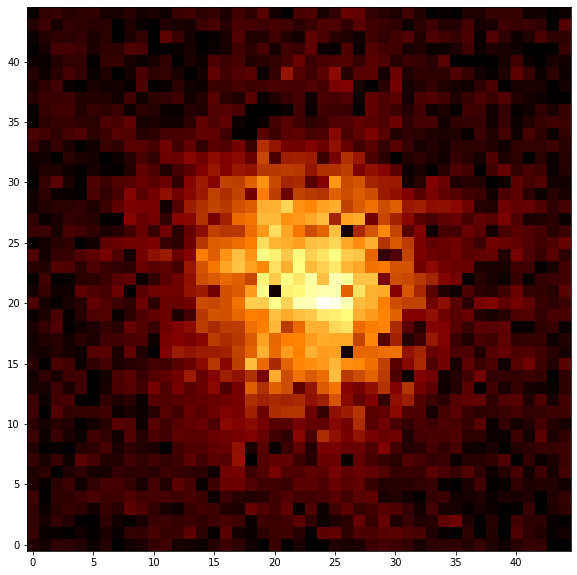

In [16]:
with fits.open('subcube_par_3C264_err_45x45_spec_100loops.fits') as hdu:

#hdu = fits.open('subcube_par_3C264_LSQ_45x45_updated.fits')

    Ha = hdu[1].data
    Ha_br = hdu[2].data
    N6583 = hdu[3].data
    N6583_br = hdu[4].data
    S6716 = hdu[5].data
    S6716_br = hdu[6].data
    S6731 = hdu[7].data
    S6731_br = hdu[8].data
    hdu.close()

plt.figure(figsize=(10,10))
plt.imshow(Ha_br,cmap='afmhot',origin='lower')

In [12]:
#hdu.open=('subcube_par_HE0232-0900_LSQ2.fits')
#Hb_blr = hdu[5].data
#OIII_nr = hdu[2].data
#OIII_br = hdu[3].data
#hdu.close()
#Hb_blr_centroid = ndimage.measurements.center_of_mass(Hb_blr)
#OIII_nr_centroid = ndimage.measurements.center_of_mass(OIII_nr)
#OIII_br_centroid = ndimage.measurements.center_of_mass(OIII_br)
#print('Centroid of Hb_blr is: ',Hb_blr_centroid)
#print('Centroid of OIII_nr is: ',OIII_nr_centroid)
#print('Centroid of OIII_br is: ',OIII_br_centroid)

In [13]:
#outflow_size_pix = np.sqrt((OIII_br_centroid[0] -  Hb_blr_centroid[0])**2 + (OIII_br_centroid[1] -  Hb_blr_centroid[1])**2)
#outflow_size_arc = 0.4*outflow_size_pix   
#print(outflow_size_arc)

In [14]:
#need distance to galaxy to find distance in parsec
#distance = 175.5
#outflow_size_parsec = (distance*outflow_size_arc)*4.848
#print(outflow_size_parsec) 
#Check MOFFAT

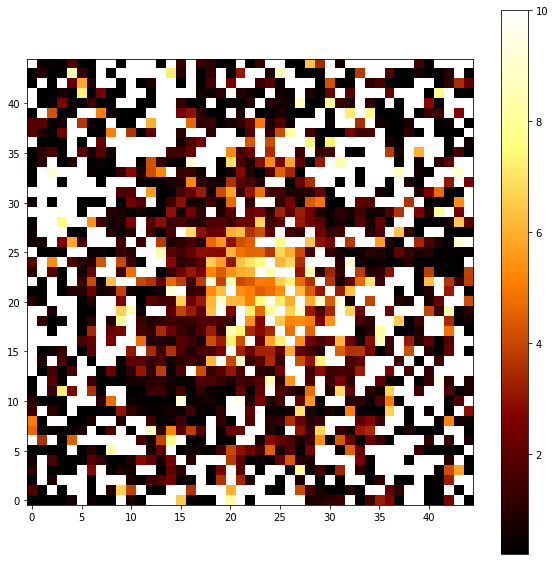

In [17]:
plt.figure(figsize=(10,10))
ratio_core = par[3,:,:]/par[1,:,:]  # N6583_br/Ha_br
ratio_wing = par[4,:,:]/par[2,:,:]  # S6716/N6583
plt.imshow(ratio_core,vmin=0.2,vmax=10,origin='lower',cmap='afmhot')  # for SII we can get the electron density from the core. core is extended so high electron density
plt.colorbar()
## NII and Ha ratio gives us the extent of ionization. Ha is not ionized, while NII is. 

In [48]:
# plt.figure(figsize=(10,10))
# smoothed_data_gauss = convolve(ratio_core, kernel)  #convolving takes the bad values and smooths them to more reasonable values. 
# plt.imshow(smoothed_data_gauss,cmap='afmhot',interpolation='none',origin='lower',vmin=0.2,vmax=10)

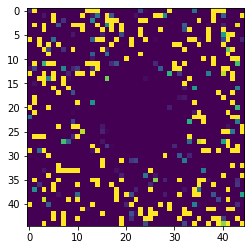

In [18]:
plt.imshow(ratio_wing,vmin=0.45,vmax=3)  # may be a pointlike outflow. If it was extended, we would see high electron density

In [50]:
# def BIC(data,model,n_free_par):
#     N = len(data)
#     BIC=stats.chisquare(data,model)[0] +n_free_par*(np.log(N) - np.log(2*np.pi))
#     return BIC